## Get Potential Subreddit

In [1]:
%load_ext autoreload
%autoreload 1
%aimport redditClient

In [2]:
import networkx as nx
from redditClient import redditClient
import matplotlib.pyplot as plt
import json

In [3]:
client = redditClient()

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


## Get potential submissions with keywords

In [4]:
# search for the post, then scrape those posts and their comments

In [ ]:
# Gatering potentially relevant posts

keywords = [
    "alice in wonderland", 
    "aliceinwonderland",
    "alice in wonderland movie",
    "aliceinwonderlandmovie", 
    "aliceinwonderlandmoviereview", 
    "alice2010", 
    "alicereview",
    "alicemoviereview",
    "aliceinwonderlandmovie-review",
    "timburton-alice",
    "timburton", 
    "miawasikowska-alice",
    "johnnydepp-alice",
    "helenabonhancarter-alice",
    "madhatter"
    "johnnydepp-alice",
    "madhatter",
    "tweedledum",
    "redqueen",
    "alice through the looking glass",
    "jabberwock"
]

# Number of top submissions per keyword (sorted by number of comments)
limit_per_keyword = 10

# Gather submissions URLs across all subreddits
submissions_urls = []
for kw in keywords:
    print(f"Searching for keyword: {kw}")
    for submission in client.subreddit('all').search(kw, sort='comments', limit=limit_per_keyword):
        submissions_urls.append(submission.url)
        
for idx, url in enumerate(submissions_urls):
    print(f"Scraping submission P{idx+1}/{len(submissions_urls)}: {url}")
        
# Save the list of URLs to JSON
with open('submission_urls.json', 'w') as f:
    json.dump({'urls': list(submissions_urls)}, f, indent=4)

Searching for keyword: johnnydepp-alice
Searching for keyword: madhatter
Searching for keyword: tweedledum
Searching for keyword: redqueen
Searching for keyword: alice through the looking glass
Searching for keyword: jabberwock
Scraping submission P1/52: https://www.reddit.com/r/movies/comments/408awi/which_actors_are_struggling_as_box_office_draws/
Scraping submission P2/52: https://www.instagram.com/p/CtYiZYcMdjz/
Scraping submission P3/52: https://www.reddit.com/r/exmormon/comments/de800a/october_2019_general_conference_sunday_200p/
Scraping submission P4/52: https://i.redd.it/iomjgkc22bjd1.png
Scraping submission P5/52: https://www.reddit.com/r/fantasyfootball/comments/jyuqvt/official_wdis_qb_sun_morning_11222020/
Scraping submission P6/52: https://www.reddit.com/r/fantasyfootball/comments/iy7zxf/official_wdis_rb_wed_morning_09232020/
Scraping submission P7/52: https://www.reddit.com/r/magicTCG/comments/3mpxow/this_friday_night_ill_be_playing_dd_with_a_deck/
Scraping submission P8/

## Scrap the Data

In [ ]:
# Scrape the submissions and their comments from the potentially relevant posts
# Prep the output structure
data = {'submissions': []}

# Load the list of URLs
with open('submission_urls.json', 'r') as f:
    submission_urls = json.load(f).get('urls', [])

def serialize_comment(comment):
    return {
        'id': comment.id,
        'author': str(comment.author),
        'created': comment.created_utc,
        'text': comment.body,
        'replies': [serialize_comment(reply) for reply in getattr(comment, 'replies', [])]
    }

# Loop and scrape
for url in submission_urls:
    try:
        submission = client.submission(url=url)
        submission.comments.replace_more(limit=None)
        comments = [serialize_comment(top_level) for top_level in submission.comments]

        data['submissions'].append({
            'title': submission.title,
            'submission_id': submission.id,
            'author': str(submission.author),
            'score': submission.score,
            'created': submission.created_utc,
            'text': submission.selftext,
            'comments': comments
        })

    except Exception as e:
        print(f"Error scraping {url}: {e}")

# Write out the final JSON
with open('alice_subreddits.json', 'w') as out_f:
    json.dump(data, out_f, indent=4)

print(f"✅ Done: {len(data['submissions'])} submissions collected.")


Error scraping https://v.redd.it/f45rd49l459b1: received 404 HTTP response
Error scraping https://v.redd.it/xssli8xcz6le1: received 404 HTTP response
Error scraping https://v.redd.it/7zg8hciyg9w71: received 404 HTTP response
✅ Done: 15 submissions collected.


In [5]:
def count_replies(comments):
    total = 0
    for comment in comments:
        replies = comment.get('replies', [])
        total += len(replies)
        total += count_replies(replies)
    return total

with open('alice_subreddits.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

submissions = data.get('submissions', [])
num_submissions = len(submissions)
num_comments = sum(len(sub.get('comments', [])) for sub in submissions)
num_replies = sum(count_replies(sub.get('comments', [])) for sub in submissions)

print(f"Number of submissions: {num_submissions}")
print(f"Number of comments: {num_comments}")
print(f"Number of replies: {num_replies}")

Number of submissions: 15
Number of comments: 3231
Number of replies: 8321


## Make Reply Graph

In [6]:
replyGraph = nx.DiGraph()
dSubCommentId = dict()

In [7]:
with open('alice_subreddits.json') as f:
    data = json.load(f)

In [8]:
sFileName = "alice_subreddits.graphml"

In [9]:
# Only add nodes/edges if author is not '[deleted]', 'None', or None
for submission in data['submissions']:
    author = submission.get('author', '[deleted]')
    if author not in ('[deleted]', 'None', None):
        if author in replyGraph:
            replyGraph.nodes[author]['subNum'] += 1
        else:
            replyGraph.add_node(author, subNum=1)

        submissionId = submission.get('submission_id')
        dSubCommentId[submissionId] = {submissionId: author}

        for comment in submission.get('comments', []):
            comment_author = comment.get('author', '[deleted]')
            comment_id = comment.get('id')
            parent_id = comment.get('parent_id', submissionId)

            # Only add if comment_author is not '[deleted]', 'None', None, or 'ExternalUserError'
            if comment_author not in ('[deleted]', 'None', None, 'ExternalUserError'):
                dSubCommentId[submissionId].update({comment_id: comment_author})

                if parent_id in dSubCommentId[submissionId]:
                    parent_author = dSubCommentId[submissionId][parent_id]
                    # Only add edge if parent_author is not '[deleted]', 'None', or None
                    if parent_author not in ('[deleted]', 'None', None):
                        if replyGraph.has_edge(comment_author, parent_author):
                            replyGraph[comment_author][parent_author]['replyNum'] += 1
                        else:
                            if not comment_author in replyGraph:
                                replyGraph.add_node(comment_author, subNum=0)
                            if not parent_author in replyGraph:
                                replyGraph.add_node(parent_author, subNum=0)
                            replyGraph.add_edge(comment_author, parent_author, replyNum=1)

print(replyGraph.nodes)
nx.readwrite.write_graphml(replyGraph, sFileName)

['mranimal2', 'danialarbab', 'buterbetterbater', 'almostamedic', 'UYScutiPuffJr', 'sushkunes', 'BallClamps', 'intent107135048', 'MilkyLikeCereal', 'ThreatconDelta', 'Trompetsnegl', 'omarcoming9439', 'Jackcooper', 'kehlery', 'murphykills', '_Volta', 'Ganthamus_prime', 'pulpexploder', 'Iusedtobeuseful', '10sharks', 'Fanybany1', 'sonia72quebec', 'saphirakal', 'reddit455', 'Sullt8', 'bmaje', 'BobJWHenderson', 'zazzlekdazzle', 'Michalusmichalus', 'FluffleCuntMuffin', 'jadamsmash', 'ldaleback', 'bocajyenrib', 'lol_camis', 'big-african-hat6991', 'Choco319', 'Kendermassacre', 'mikeyttt5', 'TheNumberMuncher', 'Notsureifsirius', 'retina99', 'QueenVell', 'Clapbakatyerblakcat', 'ClathrateRemonte', 'Blue-Steel_Rugby', 'hebreakslate', 'cinnapear', 'DarkShuffler', 'KimuraNutTrap', 'Waddlow', 'berlinblades', 'KlutchAtStraws', 'MrBrianWeldon', 'Scroobiusness', 'TheRealSofaKing', 'YoungFentanyl', 'neoslith', 'oblication', 'Good_old_Marshmallow', 'LittleIslander', 'KingYesKing', 'Redeemer206', 'my_reddit

In [10]:
G = nx.readwrite.read_graphml('alice_subreddits.graphml')
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

Total nodes: 2745
Total edges: 2781


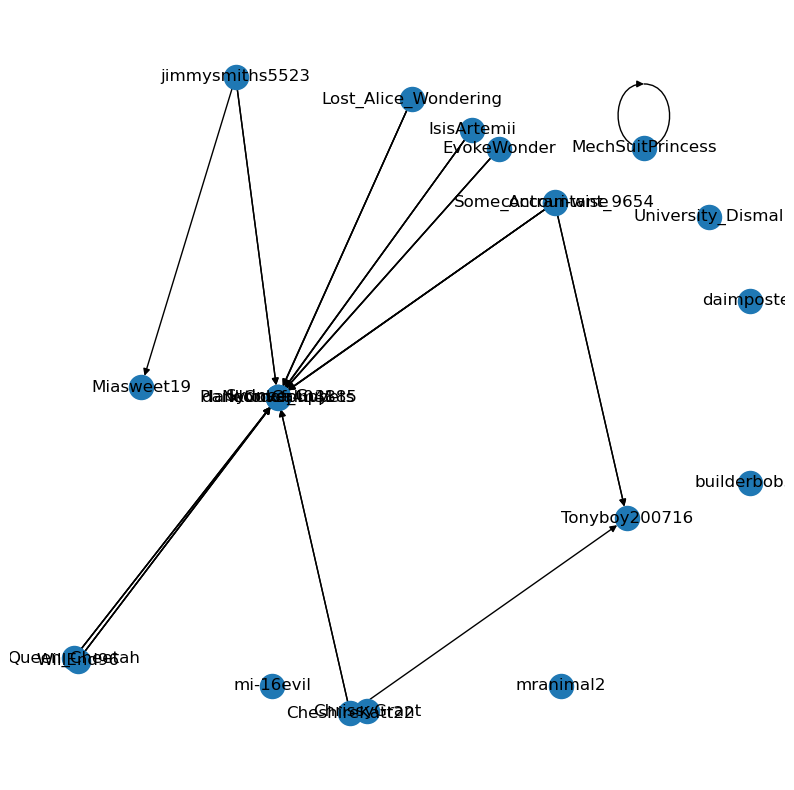

In [11]:
# Filter nodes with degree > 10
high_degree_nodes = [n for n in replyGraph.nodes if replyGraph.degree(n) > 2]

# Create a subgraph
subG = replyGraph.subgraph(high_degree_nodes).copy()

# Try drawing the subgraph
plt.figure(figsize=(10, 10))
nx.draw_networkx(subG, arrows=True, with_labels=True, pos=nx.kamada_kawai_layout(subG, scale=10))
plt.axis('off')
plt.show()

## Find Centralities

In [38]:
sFileName = 'alice_subreddits.graphml'

In [12]:
replyGraph = nx.readwrite.read_graphml(sFileName)

lDegCentrality = nx.degree_centrality(replyGraph)
lEigenvectorCentrality = nx.eigenvector_centrality(replyGraph, max_iter=1000)
lKatzCentrality = nx.katz_centrality(replyGraph)
lPageRank = nx.pagerank(replyGraph)
lClosenessCentrality = nx.closeness_centrality(replyGraph)
lBetweennessCentrality = nx.betweenness_centrality(replyGraph)

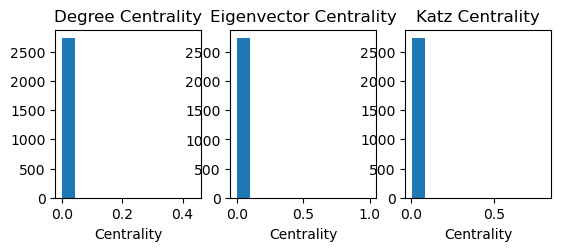

In [13]:
# Degree Centrality
plt.subplot(2, 3, 1)
plt.hist(list(lDegCentrality.values()))
plt.title("Degree Centrality")
plt.xlabel("Centrality")

# eigenvector centrality
plt.subplot(2, 3, 2)
plt.hist(list(lEigenvectorCentrality.values()))
plt.title("Eigenvector Centrality")
plt.xlabel("Centrality")
# katz centrality
plt.subplot(2, 3, 3)
plt.hist(list(lKatzCentrality.values()))
plt.title("Katz Centrality")
plt.xlabel("Centrality")

plt.show()

In [14]:
# Top 5 by lDegCentrality
top_ldeg = sorted(lDegCentrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 by lDegCentrality:")
for node, score in top_ldeg:
    print(f"{node}: {score}")

# Top 5 by lEigenvectorCentrality
top_leigen = sorted(lEigenvectorCentrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 by lEigenvectorCentrality:")
for node, score in top_leigen:
    print(f"{node}: {score}")

# Top 5 by lKatzCentrality
top_lkatz = sorted(lKatzCentrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 by lKatzCentrality:")
for node, score in top_lkatz:
    print(f"{node}: {score}")

Top 5 by lDegCentrality:
builderbob53: 0.4391399416909621
mranimal2: 0.17638483965014576
University_Dismal: 0.17128279883381925
NoCover4041: 0.038629737609329445
ChrissyGrant: 0.03534985422740525

Top 5 by lEigenvectorCentrality:
MechSuitPrincess: 0.9999995117651738
builderbob53: 0.000851278317991511
mranimal2: 0.0003419453714151065
University_Dismal: 0.00033205541128740744
NoCover4041: 7.491644796730221e-05

Top 5 by lKatzCentrality:
builderbob53: 0.8033325597358144
mranimal2: 0.32662245638641346
University_Dismal: 0.31736594952526
NoCover4041: 0.07669677113527118
ChrissyGrant: 0.07074615958167255


In [15]:
# eigenvector centrality, store in node attribute 'eigen'
for nodeId, cent in lEigenvectorCentrality.items():
    replyGraph.nodes[nodeId]['eigen'] = float(cent)
    
# Katz centrality, store in node attribute 'katz'
for nodeId, cent in lKatzCentrality.items():
    replyGraph.nodes[nodeId]['katz'] = float(cent)
    
nx.readwrite.write_graphml(replyGraph, 'mod' + sFileName, infer_numeric_types=True)

In [16]:
# Compute clustering
print('Global clustering coefficient/transitivity: {}'.format(nx.transitivity(replyGraph)))

# Compute components
print('number of strongly connected components: {}'.format(nx.number_strongly_connected_components(replyGraph)))
print('number of weakly connected components: {}'.format(nx.number_weakly_connected_components(replyGraph)))

# Compute bridges
print(list(nx.bridges(replyGraph.to_undirected())))

Global clustering coefficient/transitivity: 0
number of strongly connected components: 2745
number of weakly connected components: 7
[('mranimal2', 'danialarbab'), ('mranimal2', 'buterbetterbater'), ('mranimal2', 'almostamedic'), ('mranimal2', 'UYScutiPuffJr'), ('mranimal2', 'sushkunes'), ('mranimal2', 'BallClamps'), ('mranimal2', 'intent107135048'), ('mranimal2', 'MilkyLikeCereal'), ('mranimal2', 'ThreatconDelta'), ('mranimal2', 'Trompetsnegl'), ('mranimal2', 'omarcoming9439'), ('mranimal2', 'Jackcooper'), ('mranimal2', 'kehlery'), ('mranimal2', 'murphykills'), ('mranimal2', '_Volta'), ('mranimal2', 'Ganthamus_prime'), ('mranimal2', 'pulpexploder'), ('mranimal2', 'Iusedtobeuseful'), ('mranimal2', '10sharks'), ('mranimal2', 'Fanybany1'), ('mranimal2', 'sonia72quebec'), ('mranimal2', 'saphirakal'), ('mranimal2', 'reddit455'), ('mranimal2', 'Sullt8'), ('mranimal2', 'bmaje'), ('mranimal2', 'BobJWHenderson'), ('mranimal2', 'zazzlekdazzle'), ('mranimal2', 'Michalusmichalus'), ('mranimal2', 

In [17]:
# Compute centrality measures for the graph G
deg_centrality = nx.degree_centrality(G)

try:
	eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
except nx.PowerIterationFailedConvergence:
	print("Eigenvector centrality did not converge.")

try:
	katz_centrality = nx.katz_centrality(G, max_iter=1000)
except nx.PowerIterationFailedConvergence:
	print("Katz centrality did not converge.")

print("Degree Centrality (sample):", dict(list(deg_centrality.items())[:5]))
if 'eigenvector_centrality' in locals():
	print("Eigenvector Centrality (sample):", dict(list(eigenvector_centrality.items())[:5]))
if 'katz_centrality' in locals():
	print("Katz Centrality (sample):", dict(list(katz_centrality.items())[:5]))


Degree Centrality (sample): {'mranimal2': 0.17638483965014576, 'danialarbab': 0.00036443148688046647, 'buterbetterbater': 0.00036443148688046647, 'almostamedic': 0.00036443148688046647, 'UYScutiPuffJr': 0.00036443148688046647}
Eigenvector Centrality (sample): {'mranimal2': 0.0003419453714151065, 'danialarbab': 3.532128617034531e-08, 'buterbetterbater': 3.532128617034531e-08, 'almostamedic': 3.532128617034531e-08, 'UYScutiPuffJr': 3.532128617034531e-08}
Katz Centrality (sample): {'mranimal2': 0.32662245638641346, 'danialarbab': 0.006611790615109583, 'buterbetterbater': 0.006611790615109583, 'almostamedic': 0.006611790615109583, 'UYScutiPuffJr': 0.006611790615109583}


## Community Detection

In [18]:
import community

In [19]:
def dictToSetFormat(dComms, maxCommNum):
    lGroundTruth = [set() for i in range(maxCommNum)]
    for (name, clusId) in dComms.items():
        lGroundTruth[clusId].add(name)
    return lGroundTruth

In [20]:
replyGraph = nx.readwrite.read_graphml(sFileName)

# Implement CPM
k=3
lCpmComms = list(nx.algorithms.community.k_clique_communities(nx.to_undirected(replyGraph), k=k))
print('Number of communities found: {}'.format(len(lCpmComms)))

# Implement Louvain
dLouvainComms = community.best_partition(replyGraph.to_undirected())
print(dLouvainComms)

louvanCommNum = max([y for (x,y) in dLouvainComms.items()]) + 1
lLouvainComms = dictToSetFormat(dLouvainComms, louvanCommNum)

# Write out cpm and Louvain values to node attributes of graph
# cpm labels, stored in node attribute 'cpmClusId'
for clusId, lComms in enumerate(lCpmComms):
    for nodeId in lComms:
        replyGraph.nodes[nodeId]['cpmClusId'] = clusId
        
# louvain labels, stored in node attribute 'louvain'
for clusId, lComms in enumerate(lLouvainComms):
    for nodeId in lComms:
        replyGraph.nodes[nodeId]['louvain'] = clusId
        
nx.readwrite.write_graphml(replyGraph, 'mod2' + sFileName, infer_numeric_types=True)

Number of communities found: 0
{'mranimal2': 0, 'danialarbab': 0, 'buterbetterbater': 0, 'almostamedic': 0, 'UYScutiPuffJr': 0, 'sushkunes': 0, 'BallClamps': 0, 'intent107135048': 0, 'MilkyLikeCereal': 0, 'ThreatconDelta': 0, 'Trompetsnegl': 0, 'omarcoming9439': 0, 'Jackcooper': 0, 'kehlery': 0, 'murphykills': 0, '_Volta': 0, 'Ganthamus_prime': 0, 'pulpexploder': 0, 'Iusedtobeuseful': 0, '10sharks': 0, 'Fanybany1': 0, 'sonia72quebec': 0, 'saphirakal': 0, 'reddit455': 0, 'Sullt8': 0, 'bmaje': 0, 'BobJWHenderson': 0, 'zazzlekdazzle': 0, 'Michalusmichalus': 0, 'FluffleCuntMuffin': 0, 'jadamsmash': 0, 'ldaleback': 0, 'bocajyenrib': 0, 'lol_camis': 0, 'big-african-hat6991': 0, 'Choco319': 0, 'Kendermassacre': 0, 'mikeyttt5': 0, 'TheNumberMuncher': 0, 'Notsureifsirius': 0, 'retina99': 0, 'QueenVell': 0, 'Clapbakatyerblakcat': 0, 'ClathrateRemonte': 0, 'Blue-Steel_Rugby': 0, 'hebreakslate': 0, 'cinnapear': 0, 'DarkShuffler': 0, 'KimuraNutTrap': 0, 'Waddlow': 0, 'berlinblades': 0, 'KlutchAtStr